In [ ]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import pandas as pd
import time
from sklearn.metrics import confusion_matrix
import mediapipe as mp
import glob
import tensorflow
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Flatten, Input, Dropout, InputLayer
from keras.callbacks import TensorBoard
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, precision_score, f1_score, recall_score, accuracy_score
from keras.utils.np_utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import plot_model
import pickle

In [ ]:
DATA_PATH = os.path.join('./sign_Data') 
path = os.path.join(os.getcwd()+'/sign_Data')
dirs = os.listdir(path)
excluded = ['Normalized','Original']
actions = []
for i in dirs :
    if i in excluded:
        continue
    else:
        actions.append(i)
# actions = actions
# actions = ['Bahwa','Dengan','Dia','Ini','Jadi','Mereka','Satu','Saya','Sebagai','Untuk']
actions

['Akan',
 'Anda',
 'Apa',
 'Atau',
 'Baca',
 'Bagaimana',
 'Bahwa',
 'Beberapa',
 'Besar',
 'Bisa',
 'Buah',
 'Dan',
 'Dari',
 'Dengan',
 'Dia',
 'Haus',
 'Ingin',
 'Ini',
 'Itu',
 'Jadi',
 'Juga',
 'Kami',
 'Kata',
 'Kecil',
 'Kumpul',
 'Labuh',
 'Lain',
 'Laku',
 'Lapar',
 'Main',
 'Makan',
 'Masing',
 'Mereka',
 'Milik',
 'Minum',
 'Oleh',
 'Pada',
 'Rumah',
 'Satu',
 'Saya',
 'Sebagai',
 'Tambah',
 'Tangan',
 'Tetapi',
 'Tidak',
 'Tiga',
 'Udara',
 'Untuk',
 'Waktu',
 'Yang']

In [ ]:
label_map = {label:num for num, label in enumerate(actions)}
label_map

{'Akan': 0,
 'Anda': 1,
 'Apa': 2,
 'Atau': 3,
 'Baca': 4,
 'Bagaimana': 5,
 'Bahwa': 6,
 'Beberapa': 7,
 'Besar': 8,
 'Bisa': 9,
 'Buah': 10,
 'Dan': 11,
 'Dari': 12,
 'Dengan': 13,
 'Dia': 14,
 'Haus': 15,
 'Ingin': 16,
 'Ini': 17,
 'Itu': 18,
 'Jadi': 19,
 'Juga': 20,
 'Kami': 21,
 'Kata': 22,
 'Kecil': 23,
 'Kumpul': 24,
 'Labuh': 25,
 'Lain': 26,
 'Laku': 27,
 'Lapar': 28,
 'Main': 29,
 'Makan': 30,
 'Masing': 31,
 'Mereka': 32,
 'Milik': 33,
 'Minum': 34,
 'Oleh': 35,
 'Pada': 36,
 'Rumah': 37,
 'Satu': 38,
 'Saya': 39,
 'Sebagai': 40,
 'Tambah': 41,
 'Tangan': 42,
 'Tetapi': 43,
 'Tidak': 44,
 'Tiga': 45,
 'Udara': 46,
 'Untuk': 47,
 'Waktu': 48,
 'Yang': 49}

In [ ]:
def iterate_data(basepath,vid,action,key='normal'):
    sequences = []
    status = 0
    last_frame = 0

    #DATA_PATH = os.path.join('./Preprocess Workspace/GenerateImage') 
    DATA_PATH = basepath
    if key == 'normal': 
        for frame_num in range(0,120):
                
            if os.path.exists(os.path.join(DATA_PATH, action, str(vid), str(frame_num),"{}_normalized.pkl".format(frame_num))):
                res = pickle.load(open((os.path.join(DATA_PATH, action, str(vid), str(frame_num),"{}_normalized.pkl".format(frame_num))),'rb'))
                last_frame = frame_num
                #print(action, frame_num, vid)
            else:
                res = pickle.load(open((os.path.join(DATA_PATH, action, str(vid), str(last_frame),"{}_normalized.pkl".format(last_frame))),'rb'))
                #print(str(os.path.join(DATA_PATH, action, str(vid), str(frame_num),"{}_normalized.pkl".format(frame_num)))+" Not Found.")
            sequences.append(res)
        status = 1

    elif key == 'origin': 
        for frame_num in range(0,120):
                
            if os.path.exists(os.path.join(DATA_PATH, action, str(vid), str(frame_num),"{}_original.pkl".format(frame_num))):
                res = pickle.load(open((os.path.join(DATA_PATH, action, str(vid), str(frame_num),"{}_original.pkl".format(frame_num))),'rb'))
                last_frame = frame_num
                #print(action, frame_num, vid)
            else:
                res = pickle.load(open((os.path.join(DATA_PATH, action, str(vid), str(last_frame),"{}_original.pkl".format(last_frame))),'rb'))
                #print(str(os.path.join(DATA_PATH, action, str(vid), str(frame_num),"{}_original.pkl".format(frame_num)))+" Not Found.")
            sequences.append(res)
        status = 1

    elif key == 'aug_atas':
        for frame_num in range(0,120):
           
            if os.path.exists(os.path.join(DATA_PATH, action, str(vid), str(frame_num),"{}_norm_aug_atas.pkl".format(frame_num))):
                res2 = pickle.load(open((os.path.join(DATA_PATH, action, str(vid), str(frame_num),"{}_norm_aug_atas.pkl".format(frame_num))),'rb'))
                last_frame = frame_num
                #print(action, frame_num, vid, "Augmented Atas Data Found")
            else:
                res2 = pickle.load(open((os.path.join(DATA_PATH, action, str(vid), str(last_frame),"{}_norm_aug_atas.pkl".format(last_frame))),'rb'))
                #print(str(os.path.join(DATA_PATH, action, str(vid), str(frame_num),"{}_normalized.pkl".format(frame_num)))+" Not Found.")
            sequences.append(res2)
        status = 1
    elif key == 'aug_bawah':
        for frame_num in range(0,120):
           
            if os.path.exists(os.path.join(DATA_PATH, action, str(vid), str(frame_num),"{}_norm_aug_bawah.pkl".format(frame_num))):
                res3 = pickle.load(open((os.path.join(DATA_PATH, action, str(vid), str(frame_num),"{}_norm_aug_bawah.pkl".format(frame_num))),'rb'))
                last_frame = frame_num
                #print(action, frame_num, vid, "Augmented Bawah Data Found")
            else:
                res3 = pickle.load(open((os.path.join(DATA_PATH,action, str(vid), str(last_frame),"{}_norm_aug_bawah.pkl".format(last_frame))),'rb'))
                #print(str(os.path.join(DATA_PATH, action, str(vid), str(frame_num),"{}_normalized.pkl".format(frame_num)))+" Not Found.")
            sequences.append(res3)
        status = 1
    elif key == 'aug_kanan':
        for frame_num in range(0,120):
            
            if os.path.exists(os.path.join(DATA_PATH, action, str(vid), str(frame_num),"{}_norm_aug_kanan.pkl".format(frame_num))):
                res4 = pickle.load(open((os.path.join(DATA_PATH, action, str(vid), str(frame_num),"{}_norm_aug_kanan.pkl".format(frame_num))),'rb'))
                last_frame = frame_num
                #print(action, frame_num, vid, "Augmented Kanan Data Found")
            else:
                res4 = pickle.load(open((os.path.join(DATA_PATH, action, str(vid), str(last_frame),"{}_norm_aug_kanan.pkl".format(last_frame))),'rb'))
                #print(str(os.path.join(DATA_PATH, action, str(vid), str(frame_num),"{}_normalized.pkl".format(frame_num)))+" Not Found.")
            sequences.append(res4)
        status = 1
    elif key == 'aug_kiri':
        for frame_num in range(0,120):
           
            if os.path.exists(os.path.join(DATA_PATH, action, str(vid), str(frame_num),"{}_norm_aug_kiri.pkl".format(frame_num))):
                res5 = pickle.load(open((os.path.join(DATA_PATH, action, str(vid), str(frame_num),"{}_norm_aug_kiri.pkl".format(frame_num))),'rb'))
                last_frame = frame_num
                #print(action, frame_num, vid, "Augmented Kiri Data Found")
            else:
                res5 = pickle.load(open((os.path.join(DATA_PATH, action, str(vid), str(last_frame),"{}_norm_aug_kiri.pkl".format(last_frame))),'rb'))
                #print(str(os.path.join(DATA_PATH, action, str(vid), str(frame_num),"{}_normalized.pkl".format(frame_num)))+" Not Found.")
            sequences.append(res5)
        status = 1

    return sequences, action, status
        

In [26]:
vids, labels = [], []
for action in actions:
    for vid in range(0,20):
       
        DATA_PATH = os.path.join('./') 
        
        # for frame_num in range(0,120):
        base_sequence, action_base, status_base = iterate_data(os.path.join(DATA_PATH,'sign_Data'), vid, action, 'normal')
        vids.append(base_sequence)
        labels.append(label_map[action])
        aug_right_seq, action_right, status_right = iterate_data(os.path.join(DATA_PATH,'sign_Data'), vid, action, 'aug_kanan')
        vids.append(aug_right_seq)
        labels.append(label_map[action])
        aug_left_seq, action_left, status_left = iterate_data(os.path.join(DATA_PATH,'sign_Data'), vid, action, 'aug_kiri')
        vids.append(aug_left_seq)
        labels.append(label_map[action])
        aug_up_seq, action_up, status_up = iterate_data(os.path.join(DATA_PATH,'sign_Data'), vid, action, 'aug_atas')
        vids.append(aug_up_seq)
        labels.append(label_map[action])
        aug_down_seq, action_down, status_down = iterate_data(os.path.join(DATA_PATH,'sign_Data'), vid, action, 'aug_bawah')
        vids.append(aug_down_seq)
        labels.append(label_map[action])

     
    
      
        

In [27]:
X = np.array(vids)
y = to_categorical(labels).astype(int)

In [28]:
len(vids)

5000

In [29]:
len(labels)

5000

In [30]:
X = np.reshape(X,[5000,120,225])

In [31]:
from sklearn.model_selection import train_test_split

# Splitting the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, shuffle=True)

# Further splitting the train set into normalized and augmented data
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5, stratify=y_test, shuffle=True)


In [32]:
X_train.shape

(3500, 120, 225)

In [34]:
X_test.shape

(750, 120, 225)

In [35]:
X_valid.shape

(750, 120, 225)

In [28]:
X_train = np.concatenate((X_train_norm, X_train_aug), axis=0)

In [29]:
X_train.shape

(4000, 120, 225)

In [30]:
y_train = np.concatenate((y_train_norm, y_train_aug), axis=0)

In [36]:
y_train.shape

(3500, 50)

In [37]:
import tensorflow as tf
from tensorflow.keras import layers

def create_transformer_model(sequence_length, num_features, num_classes, num_layers, hidden_units, num_heads, dropout_rate):
    # Input Layer
    inputs = layers.Input(shape=(sequence_length, num_features))
    x = inputs

    # Positional Encoding Layer
    positional_encoding = layers.Embedding(input_dim=sequence_length, output_dim=num_features)(tf.range(sequence_length))
    x += positional_encoding

    # Encoder Layers
    for _ in range(num_layers):
        # Multi-Head Attention
        attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=num_features)(x, x)
        attention = layers.Dropout(rate=dropout_rate)(attention)
        attention = layers.LayerNormalization(epsilon=1e-6)(attention + x)

        # Feed Forward Neural Network
        ffn = layers.Dense(units=hidden_units, activation='relu')(attention)
        ffn = layers.Dropout(rate=dropout_rate)(ffn)
        ffn = layers.LayerNormalization(epsilon=1e-6)(ffn + attention)

        x = ffn

    # Global Average Pooling
    x = layers.GlobalAveragePooling1D()(x)

    # Output Layer
    outputs = layers.Dense(units=num_classes, activation='softmax')(x)

    # Create and compile the model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model


# Normal

In [51]:
# Create the model
model1 = create_transformer_model(X_train.shape[1],X_train.shape[2],50,1,225,4,0.2)
model2 = create_transformer_model(X_train.shape[1],X_train.shape[2],50,1,225,4,0.2)

# **50 Epoch**

In [52]:
start_time = time.time()

history1 = model1.fit(X_train, y_train, batch_size=64, epochs=50, validation_data=(X_valid, y_valid))

end_time = time.time()
training_time = end_time - start_time
print("Training Time:", training_time, "seconds")

Epoch 1/50
55/55 [==============================] - 28s 487ms/step - loss: 3.8211 - accuracy: 0.0591 - val_loss: 3.1831 - val_accuracy: 0.1347
Epoch 2/50
55/55 [==============================] - 28s 514ms/step - loss: 2.7189 - accuracy: 0.2154 - val_loss: 2.3781 - val_accuracy: 0.2880
Epoch 3/50
55/55 [==============================] - 27s 492ms/step - loss: 2.1062 - accuracy: 0.3411 - val_loss: 1.9252 - val_accuracy: 0.4160
Epoch 4/50
55/55 [==============================] - 27s 496ms/step - loss: 1.7113 - accuracy: 0.4600 - val_loss: 1.6886 - val_accuracy: 0.4720
Epoch 5/50
55/55 [==============================] - 27s 496ms/step - loss: 1.4127 - accuracy: 0.5623 - val_loss: 1.4122 - val_accuracy: 0.5533
Epoch 6/50
55/55 [==============================] - 27s 497ms/step - loss: 1.1307 - accuracy: 0.6623 - val_loss: 1.1404 - val_accuracy: 0.6333
Epoch 7/50
55/55 [==============================] - 27s 498ms/step - loss: 0.9685 - accuracy: 0.7080 - val_loss: 0.9370 - val_accuracy: 0.6853

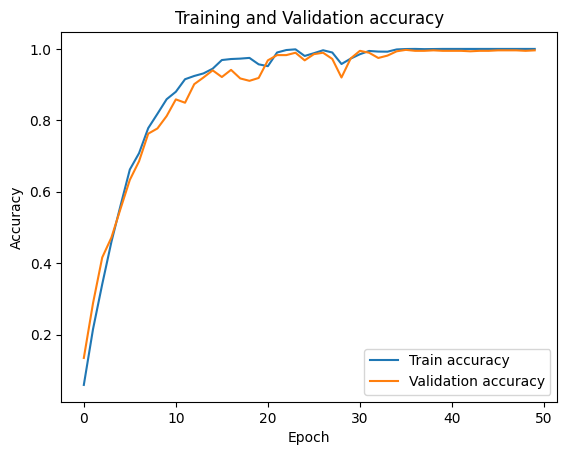

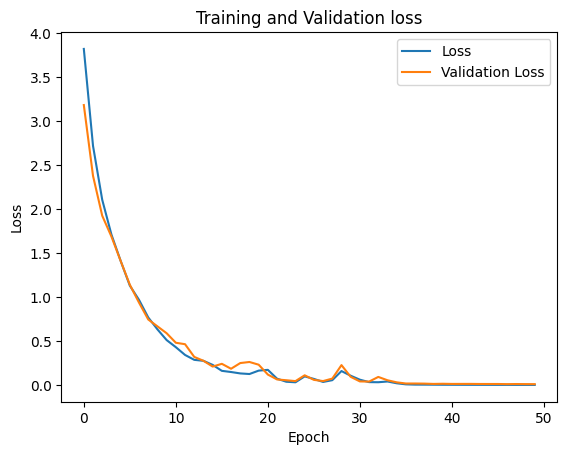

In [53]:
# Plot the training and validation loss curves
plt.plot(history1.history['accuracy'], label='Train accuracy')
plt.plot(history1.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot the training and validation loss curves
plt.plot(history1.history['loss'], label='Loss')
plt.plot(history1.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [54]:
score_1 = model1.evaluate(X_test,y_test,verbose=0)

In [55]:
print(score_1)

[0.014186943881213665, 0.9959999918937683]


# **40 Epoch**

In [56]:
start_time = time.time()
history2 = model2.fit(X_train, y_train, batch_size=64, epochs=40, validation_data=(X_valid, y_valid))

end_time = time.time()
training_time = end_time - start_time
print("Training Time:", training_time, "seconds")

Epoch 1/40
55/55 [==============================] - 30s 523ms/step - loss: 3.7429 - accuracy: 0.0640 - val_loss: 3.0961 - val_accuracy: 0.1320
Epoch 2/40
55/55 [==============================] - 28s 513ms/step - loss: 2.6693 - accuracy: 0.2017 - val_loss: 2.4000 - val_accuracy: 0.2707
Epoch 3/40
55/55 [==============================] - 28s 515ms/step - loss: 2.0599 - accuracy: 0.3571 - val_loss: 1.8750 - val_accuracy: 0.4147
Epoch 4/40
55/55 [==============================] - 28s 513ms/step - loss: 1.6624 - accuracy: 0.4717 - val_loss: 1.5831 - val_accuracy: 0.5080
Epoch 5/40
55/55 [==============================] - 28s 515ms/step - loss: 1.4096 - accuracy: 0.5611 - val_loss: 1.4815 - val_accuracy: 0.5387
Epoch 6/40
55/55 [==============================] - 28s 515ms/step - loss: 1.2129 - accuracy: 0.6231 - val_loss: 1.1038 - val_accuracy: 0.6640
Epoch 7/40
55/55 [==============================] - 28s 512ms/step - loss: 1.0042 - accuracy: 0.6946 - val_loss: 0.9210 - val_accuracy: 0.6987

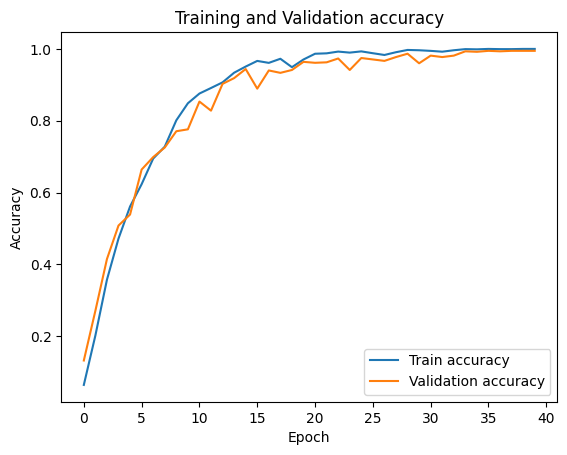

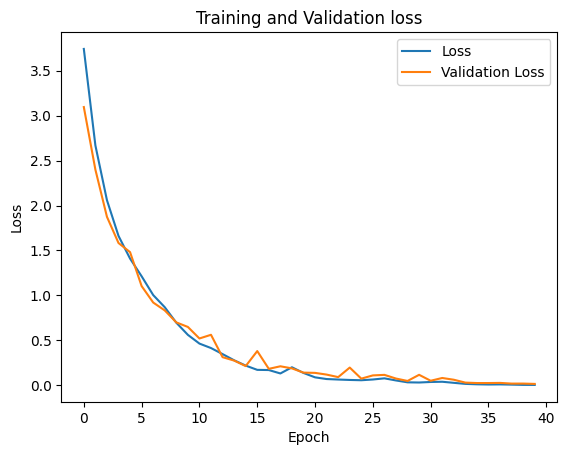

In [57]:
# Plot the training and validation loss curves
plt.plot(history2.history['accuracy'], label='Train accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot the training and validation loss curves
plt.plot(history2.history['loss'], label='Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Multihead Case

In [58]:
# Create the model
model_mh_1 = create_transformer_model(X_train.shape[1],X_train.shape[2],50,1,225,8,0.2)
model_mh_2 = create_transformer_model(X_train.shape[1],X_train.shape[2],50,1,225,8,0.2)

## **50 Epoch**

In [59]:
start_time = time.time()
history_mh_1 = model_mh_1.fit(X_train, y_train, batch_size=64, epochs=50, validation_data=(X_valid, y_valid))

end_time = time.time()
training_time = end_time - start_time
print("Training Time:", training_time, "seconds")

Epoch 1/50
55/55 [==============================] - 54s 965ms/step - loss: 3.7766 - accuracy: 0.0577 - val_loss: 3.1607 - val_accuracy: 0.1347
Epoch 2/50
55/55 [==============================] - 52s 951ms/step - loss: 2.6353 - accuracy: 0.2086 - val_loss: 2.3543 - val_accuracy: 0.2773
Epoch 3/50
55/55 [==============================] - 52s 940ms/step - loss: 1.9604 - accuracy: 0.3783 - val_loss: 1.9048 - val_accuracy: 0.3920
Epoch 4/50
55/55 [==============================] - 52s 946ms/step - loss: 1.5145 - accuracy: 0.5243 - val_loss: 1.4723 - val_accuracy: 0.5107
Epoch 5/50
55/55 [==============================] - 52s 948ms/step - loss: 1.2346 - accuracy: 0.6169 - val_loss: 1.2721 - val_accuracy: 0.5720
Epoch 6/50
55/55 [==============================] - 52s 946ms/step - loss: 0.9553 - accuracy: 0.7131 - val_loss: 1.0165 - val_accuracy: 0.6880
Epoch 7/50
55/55 [==============================] - 52s 951ms/step - loss: 0.7958 - accuracy: 0.7629 - val_loss: 0.7737 - val_accuracy: 0.7587

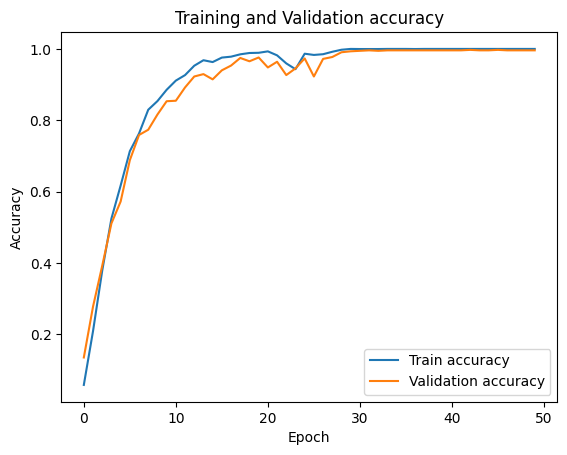

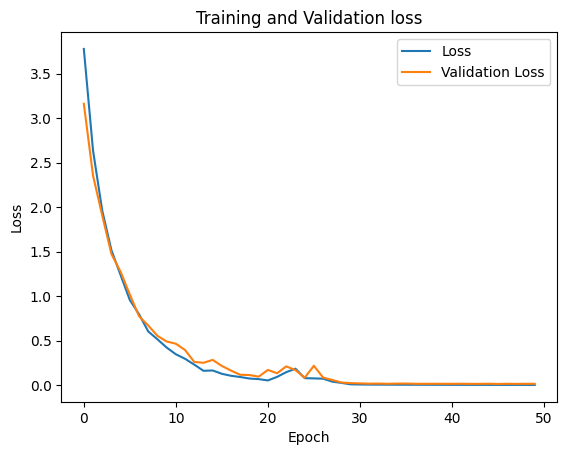

In [60]:
# Plot the training and validation loss curves
plt.plot(history_mh_1.history['accuracy'], label='Train accuracy')
plt.plot(history_mh_1.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot the training and validation loss curves
plt.plot(history_mh_1.history['loss'], label='Loss')
plt.plot(history_mh_1.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## **40 Epoch**

In [61]:
start_time = time.time()
history_mh_2 = model_mh_2.fit(X_train, y_train, batch_size=64, epochs=40, validation_data=(X_valid, y_valid))

end_time = time.time()
training_time = end_time - start_time
print("Training Time:", training_time, "seconds")

Epoch 1/40
55/55 [==============================] - 52s 924ms/step - loss: 3.7792 - accuracy: 0.0523 - val_loss: 3.0693 - val_accuracy: 0.1160
Epoch 2/40
55/55 [==============================] - 51s 926ms/step - loss: 2.5800 - accuracy: 0.2360 - val_loss: 2.2319 - val_accuracy: 0.2733
Epoch 3/40
55/55 [==============================] - 52s 940ms/step - loss: 1.9417 - accuracy: 0.3926 - val_loss: 1.6890 - val_accuracy: 0.4627
Epoch 4/40
55/55 [==============================] - 51s 931ms/step - loss: 1.4379 - accuracy: 0.5443 - val_loss: 1.2847 - val_accuracy: 0.5827
Epoch 5/40
55/55 [==============================] - 51s 931ms/step - loss: 1.1795 - accuracy: 0.6351 - val_loss: 1.1762 - val_accuracy: 0.6147
Epoch 6/40
55/55 [==============================] - 51s 930ms/step - loss: 0.9124 - accuracy: 0.7211 - val_loss: 0.9372 - val_accuracy: 0.6867
Epoch 7/40
55/55 [==============================] - 51s 935ms/step - loss: 0.7352 - accuracy: 0.7763 - val_loss: 1.0810 - val_accuracy: 0.6627

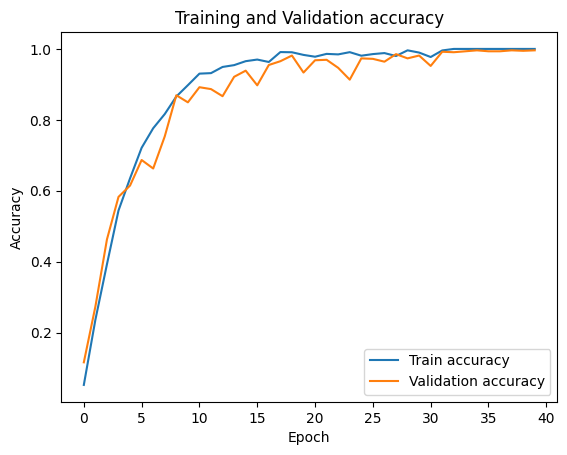

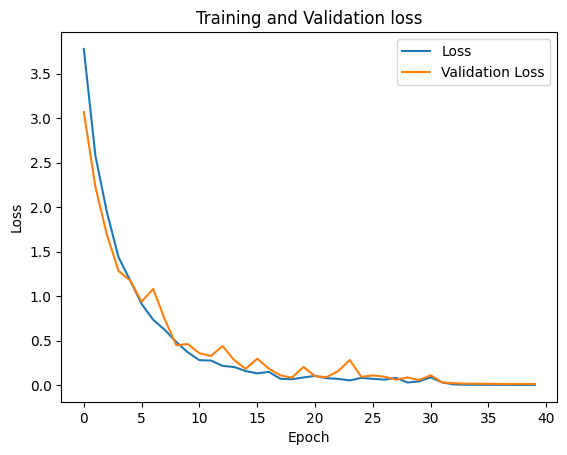

In [62]:
# Plot the training and validation loss curves
plt.plot(history_mh_2.history['accuracy'], label='Train accuracy')
plt.plot(history_mh_2.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot the training and validation loss curves
plt.plot(history_mh_2.history['loss'], label='Loss')
plt.plot(history_mh_2.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Encoder Layers

In [63]:
# Create the model
model_l_1 = create_transformer_model(X_train.shape[1],X_train.shape[2],50,2,225,4,0.2)
model_l_2 = create_transformer_model(X_train.shape[1],X_train.shape[2],50,2,225,4,0.2)

## **50 Epoch**

In [64]:
start_time = time.time()
history_l_1 = model_l_1.fit(X_train, y_train, batch_size=64, epochs=50, validation_data=(X_valid, y_valid))

end_time = time.time()
training_time = end_time - start_time
print("Training Time:", training_time, "seconds")

Epoch 1/50
55/55 [==============================] - 62s 1s/step - loss: 3.9100 - accuracy: 0.0537 - val_loss: 3.3335 - val_accuracy: 0.1027
Epoch 2/50
55/55 [==============================] - 59s 1s/step - loss: 2.7842 - accuracy: 0.1817 - val_loss: 2.4753 - val_accuracy: 0.2387
Epoch 3/50
55/55 [==============================] - 59s 1s/step - loss: 2.2210 - accuracy: 0.2969 - val_loss: 1.8788 - val_accuracy: 0.4067
Epoch 4/50
55/55 [==============================] - 58s 1s/step - loss: 1.7862 - accuracy: 0.4240 - val_loss: 1.6719 - val_accuracy: 0.4707
Epoch 5/50
55/55 [==============================] - 59s 1s/step - loss: 1.5466 - accuracy: 0.5046 - val_loss: 1.4227 - val_accuracy: 0.5613
Epoch 6/50
55/55 [==============================] - 59s 1s/step - loss: 1.2470 - accuracy: 0.5909 - val_loss: 1.2404 - val_accuracy: 0.6027
Epoch 7/50
55/55 [==============================] - 58s 1s/step - loss: 1.0492 - accuracy: 0.6606 - val_loss: 1.0594 - val_accuracy: 0.6520
Epoch 8/50
55/55 [==

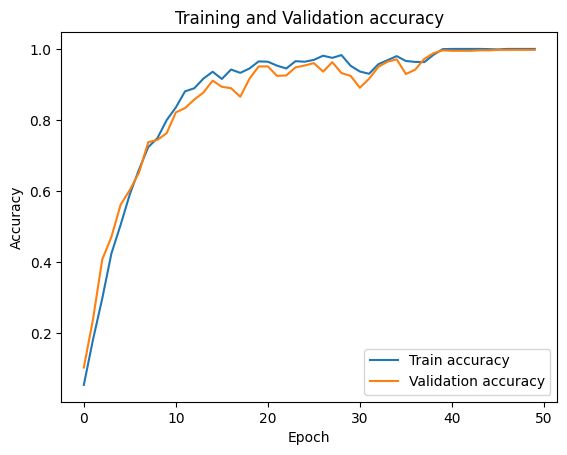

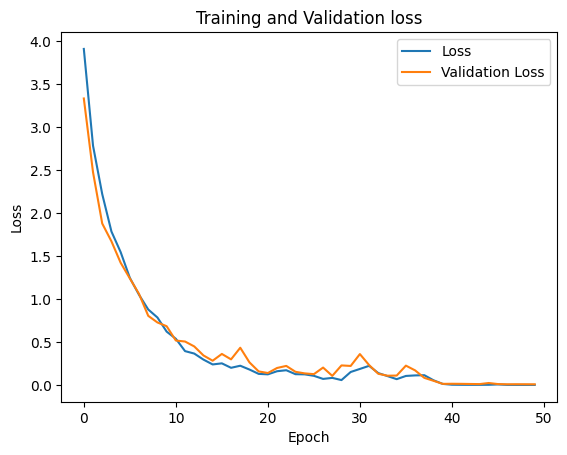

In [65]:
# Plot the training and validation loss curves
plt.plot(history_l_1.history['accuracy'], label='Train accuracy')
plt.plot(history_l_1.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot the training and validation loss curves
plt.plot(history_l_1.history['loss'], label='Loss')
plt.plot(history_l_1.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## **40 Epoch**

In [66]:
start_time = time.time()
history_l_2 = model_l_2.fit(X_train, y_train, batch_size=64, epochs=40, validation_data=(X_valid, y_valid))

end_time = time.time()
training_time = end_time - start_time
print("Training Time:", training_time, "seconds")

Epoch 1/40
55/55 [==============================] - 62s 1s/step - loss: 3.7196 - accuracy: 0.0703 - val_loss: 2.9920 - val_accuracy: 0.1747
Epoch 2/40
55/55 [==============================] - 60s 1s/step - loss: 2.5827 - accuracy: 0.2269 - val_loss: 2.2813 - val_accuracy: 0.2827
Epoch 3/40
55/55 [==============================] - 60s 1s/step - loss: 1.9806 - accuracy: 0.3637 - val_loss: 1.8775 - val_accuracy: 0.3947
Epoch 4/40
55/55 [==============================] - 60s 1s/step - loss: 1.6194 - accuracy: 0.4860 - val_loss: 1.6564 - val_accuracy: 0.4507
Epoch 5/40
55/55 [==============================] - 60s 1s/step - loss: 1.2734 - accuracy: 0.5834 - val_loss: 1.2786 - val_accuracy: 0.5733
Epoch 6/40
55/55 [==============================] - 60s 1s/step - loss: 1.1322 - accuracy: 0.6431 - val_loss: 1.1184 - val_accuracy: 0.6453
Epoch 7/40
55/55 [==============================] - 60s 1s/step - loss: 0.9155 - accuracy: 0.7114 - val_loss: 0.8814 - val_accuracy: 0.7080
Epoch 8/40
55/55 [==

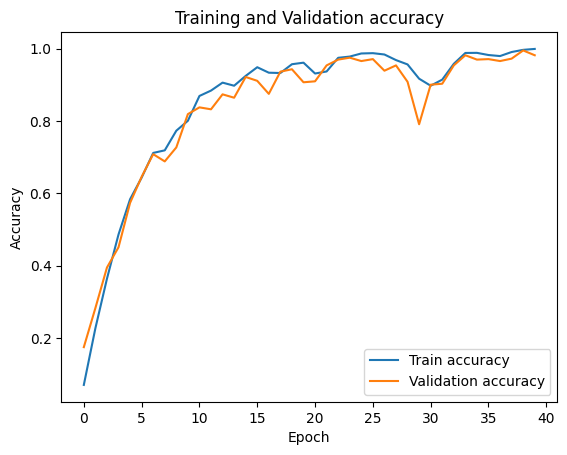

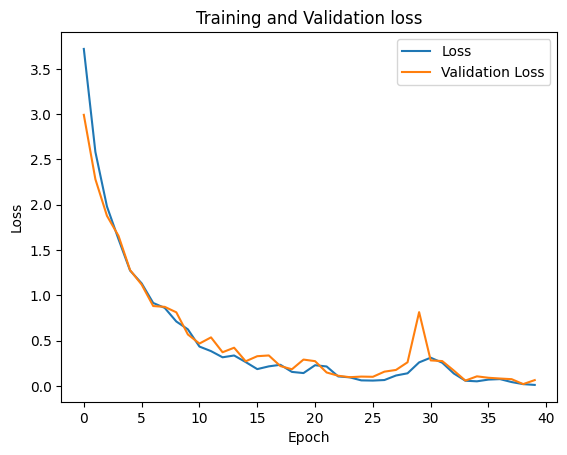

In [67]:
# Plot the training and validation loss curves
plt.plot(history_l_2.history['accuracy'], label='Train accuracy')
plt.plot(history_l_2.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot the training and validation loss curves
plt.plot(history_l_2.history['loss'], label='Loss')
plt.plot(history_l_2.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Layers + Multihead

In [68]:
# Create the model
model_lmh_1 = create_transformer_model(X_train.shape[1],X_train.shape[2],50,2,225,8,0.2)
model_lmh_2 = create_transformer_model(X_train.shape[1],X_train.shape[2],50,2,225,8,0.2)

## **50 Epoch**

In [69]:
start_time = time.time()
history_lmh_1 = model_lmh_1.fit(X_train, y_train, batch_size=64, epochs=50, validation_data=(X_valid, y_valid))

end_time = time.time()
training_time = end_time - start_time
print("Training Time:", training_time, "seconds")

Epoch 1/50
55/55 [==============================] - 115s 2s/step - loss: 4.0330 - accuracy: 0.0263 - val_loss: 3.8038 - val_accuracy: 0.0400
Epoch 2/50
55/55 [==============================] - 111s 2s/step - loss: 3.3845 - accuracy: 0.0789 - val_loss: 3.0295 - val_accuracy: 0.1213
Epoch 3/50
55/55 [==============================] - 112s 2s/step - loss: 2.7759 - accuracy: 0.1797 - val_loss: 2.4735 - val_accuracy: 0.2267
Epoch 4/50
55/55 [==============================] - 107s 2s/step - loss: 2.2809 - accuracy: 0.2811 - val_loss: 2.1771 - val_accuracy: 0.2787
Epoch 5/50
55/55 [==============================] - 113s 2s/step - loss: 1.8908 - accuracy: 0.3886 - val_loss: 1.8132 - val_accuracy: 0.3907
Epoch 6/50
55/55 [==============================] - 112s 2s/step - loss: 1.5926 - accuracy: 0.4763 - val_loss: 1.4204 - val_accuracy: 0.5013
Epoch 7/50
55/55 [==============================] - 120s 2s/step - loss: 1.2471 - accuracy: 0.5994 - val_loss: 1.3171 - val_accuracy: 0.5573
Epoch 8/50
55

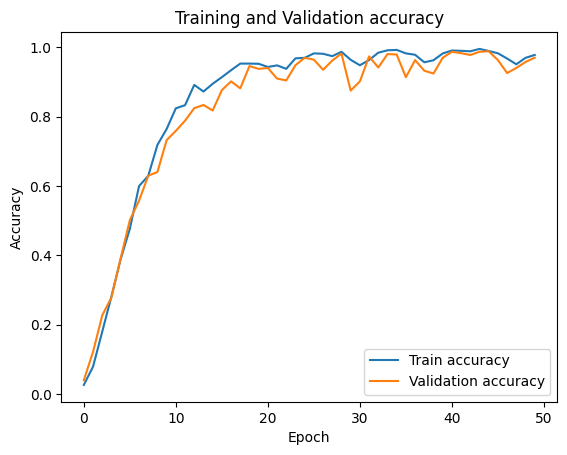

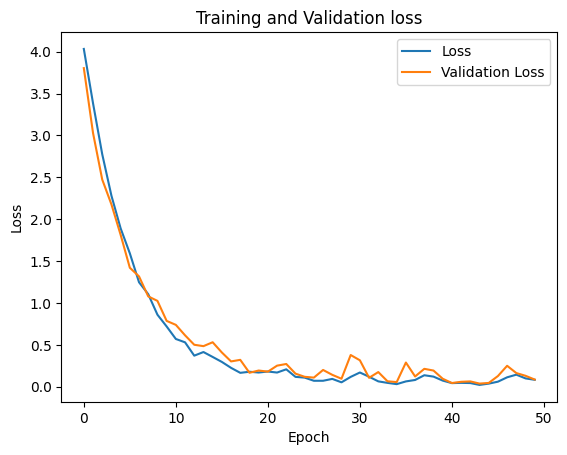

In [70]:
# Plot the training and validation loss curves
plt.plot(history_lmh_1.history['accuracy'], label='Train accuracy')
plt.plot(history_lmh_1.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot the training and validation loss curves
plt.plot(history_lmh_1.history['loss'], label='Loss')
plt.plot(history_lmh_1.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## **40 Epoch**

In [71]:
start_time = time.time()
history_lmh_2 = model_lmh_2.fit(X_train, y_train, batch_size=64, epochs=40, validation_data=(X_valid, y_valid))

end_time = time.time()
training_time = end_time - start_time
print("Training Time:", training_time, "seconds")

Epoch 1/40
55/55 [==============================] - 118s 2s/step - loss: 4.0021 - accuracy: 0.0357 - val_loss: 3.4946 - val_accuracy: 0.0667
Epoch 2/40
55/55 [==============================] - 108s 2s/step - loss: 2.9558 - accuracy: 0.1497 - val_loss: 2.5329 - val_accuracy: 0.2227
Epoch 3/40
55/55 [==============================] - 107s 2s/step - loss: 2.3575 - accuracy: 0.2569 - val_loss: 2.2854 - val_accuracy: 0.2680
Epoch 4/40
55/55 [==============================] - 107s 2s/step - loss: 1.9505 - accuracy: 0.3726 - val_loss: 1.8562 - val_accuracy: 0.3960
Epoch 5/40
55/55 [==============================] - 106s 2s/step - loss: 1.6008 - accuracy: 0.4749 - val_loss: 1.7238 - val_accuracy: 0.4080
Epoch 6/40
55/55 [==============================] - 107s 2s/step - loss: 1.3479 - accuracy: 0.5649 - val_loss: 1.3716 - val_accuracy: 0.5493
Epoch 7/40
55/55 [==============================] - 106s 2s/step - loss: 1.1685 - accuracy: 0.6157 - val_loss: 1.1570 - val_accuracy: 0.6160
Epoch 8/40
55

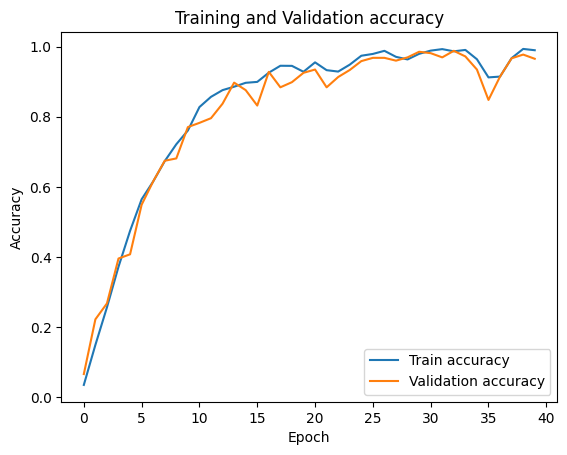

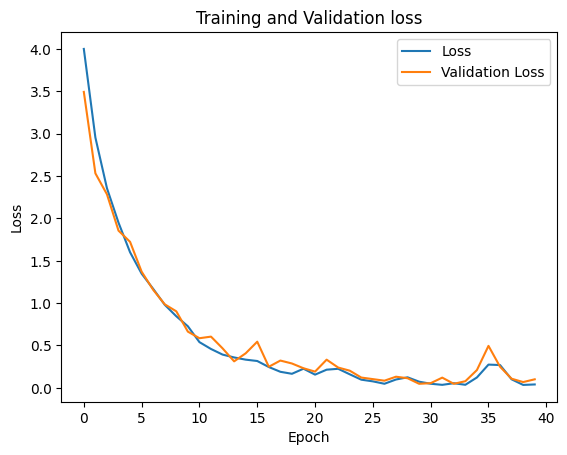

In [72]:
# Plot the training and validation loss curves
plt.plot(history_lmh_2.history['accuracy'], label='Train accuracy')
plt.plot(history_lmh_2.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot the training and validation loss curves
plt.plot(history_lmh_2.history['loss'], label='Loss')
plt.plot(history_lmh_2.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# **Save Model**

In [73]:
model1.save('Tr_FullData_50_Epoch_3.h5')
model2.save('Tr_FullData_40_Epoch_3.h5')

In [74]:
model_mh_1.save('Tr_FullData_MH_50_Epoch_3.h5')
model_mh_2.save('Tr_FullData_MH_40_Epoch_3.h5')
model_l_1.save('Tr_FullData_Layer_50_Epoch_3.h5')
model_l_2.save('Tr_FullData_Layer_40_Epoch_3.h5')
model_lmh_1.save('Tr_FullData_LMH_50_Epoch_3.h5')
model_lmh_2.save('Tr_FullData_LMH_40_Epoch_3.h5')

In [75]:
score_1 = model1.evaluate(X_test,y_test,verbose=0)
score_2 = model2.evaluate(X_test,y_test,verbose=0)
score_3 = model_mh_1.evaluate(X_test,y_test,verbose=0)
score_4 = model_mh_2.evaluate(X_test,y_test,verbose=0)
score_5 = model_l_1.evaluate(X_test,y_test,verbose=0)
score_6 = model_l_2.evaluate(X_test,y_test,verbose=0)
score_7 = model_lmh_1.evaluate(X_test,y_test,verbose=0)
score_8 = model_lmh_2.evaluate(X_test,y_test,verbose=0)

In [ ]:
scores = [score_1, score_2, score_3, score_4, score_5, score_6, score_7, score_8]

for i, score in enumerate(scores):
    print(f"Score_{i+1}: {score}")
for i in range (8)
print('Model '+ i + ' Test loss:', score_[0])
print('Test accuracy:', score[1])

In [76]:
for i in range(1, 9):
    print('Model', i, 'Test loss:', eval('score_' + str(i))[0])
    print('Model', i,'Test accuracy:', eval('score_' + str(i))[1])
    print('\n')

Model 1 Test loss: 0.014186943881213665
Model 1 Test accuracy: 0.9959999918937683


Model 2 Test loss: 0.01064816303551197
Model 2 Test accuracy: 0.9973333477973938


Model 3 Test loss: 0.014708543196320534
Model 3 Test accuracy: 0.9986666440963745


Model 4 Test loss: 0.014765607193112373
Model 4 Test accuracy: 0.9973333477973938


Model 5 Test loss: 0.010965375229716301
Model 5 Test accuracy: 0.9986666440963745


Model 6 Test loss: 0.08142346888780594
Model 6 Test accuracy: 0.9746666550636292


Model 7 Test loss: 0.06230152025818825
Model 7 Test accuracy: 0.9800000190734863


Model 8 Test loss: 0.1344176083803177
Model 8 Test accuracy: 0.9573333263397217




In [83]:
from sklearn.metrics import accuracy_score, precision_score

# Assuming you have trained your models and you want to evaluate them on the test set

models = [model1, model2, model_mh_1, model_mh_2, model_l_1, model_l_2, model_lmh_1, model_lmh_2]

for idx, model in enumerate(models):
    # Assuming you have already trained your models on the training data
    y_pred = model.predict(X_test)

    # For multilabel classification, convert the multilabel-indicator to binary
    # You can use a threshold (e.g., 0.5) to determine the binary labels
    y_test_binary = (y_test >= 0.5).astype(int)
    y_pred_binary = (y_pred >= 0.5).astype(int)

    # Calculate the accuracy
    accuracy = accuracy_score(y_test_binary, y_pred_binary)
    print(f"Model {idx+1} Accuracy: {accuracy:.4f}")

    # Calculate the precision
    precision = precision_score(y_test_binary, y_pred_binary, average='micro')  # or 'macro' or 'weighted' as needed
    print(f"Model {idx+1} Precision: {precision:.4f}")

    print()


24/24 [==============================] - 2s 93ms/step
Model 1 Accuracy: 0.9960
Model 1 Precision: 0.9960

24/24 [==============================] - 2s 96ms/step
Model 2 Accuracy: 0.9973
Model 2 Precision: 0.9987

24/24 [==============================] - 4s 166ms/step
Model 3 Accuracy: 0.9987
Model 3 Precision: 0.9987

24/24 [==============================] - 4s 171ms/step
Model 4 Accuracy: 0.9960
Model 4 Precision: 0.9973

24/24 [==============================] - 5s 187ms/step
Model 5 Accuracy: 0.9987
Model 5 Precision: 1.0000

24/24 [==============================] - 5s 186ms/step
Model 6 Accuracy: 0.9720
Model 6 Precision: 0.9785

24/24 [==============================] - 8s 332ms/step
Model 7 Accuracy: 0.9773
Model 7 Precision: 0.9813

24/24 [==============================] - 8s 336ms/step
Model 8 Accuracy: 0.9533
Model 8 Precision: 0.9610



# **Hidden**

In [32]:
model_normal_1 = create_transformer_model(X_train.shape[1],X_train.shape[2],50,1,225,4,0.2)
model_normal_2 = create_transformer_model(X_train.shape[1],X_train.shape[2],50,1,225,4,0.2)

model_normal_1.load_weights('Tr_FullData_50_Epoch.h5')
model_normal_2.load_weights('Tr_FullData_40_Epoch.h5')

In [25]:
# Create the model
model = create_transformer_model(X_train.shape[1],X_train.shape[2],50,1,225,4,0.2)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 120, 225)]   0           []                               
                                                                                                  
 tf.__operators__.add_3 (TFOpLa  (None, 120, 225)    0           ['input_2[0][0]']                
 mbda)                                                                                            
                                                                                                  
 multi_head_attention_1 (MultiH  (None, 120, 225)    812925      ['tf.__operators__.add_3[0][0]', 
 eadAttention)                                                    'tf.__operators__.add_3[0][0]'] 
                                                                                            

In [26]:
history = model.fit(X_train, y_train, batch_size=64, epochs=50, validation_data=(X_valid,y_valid))

Epoch 1/50
63/63 [==============================] - 39s 594ms/step - loss: 3.6945 - accuracy: 0.0728 - val_loss: 2.9158 - val_accuracy: 0.1620
Epoch 2/50
63/63 [==============================] - 39s 626ms/step - loss: 2.5162 - accuracy: 0.2542 - val_loss: 2.2194 - val_accuracy: 0.3270
Epoch 3/50
63/63 [==============================] - 39s 619ms/step - loss: 1.9193 - accuracy: 0.4005 - val_loss: 1.7043 - val_accuracy: 0.4480
Epoch 4/50
63/63 [==============================] - 40s 629ms/step - loss: 1.5348 - accuracy: 0.5245 - val_loss: 1.5549 - val_accuracy: 0.4910
Epoch 5/50
63/63 [==============================] - 41s 650ms/step - loss: 1.2369 - accuracy: 0.6283 - val_loss: 1.0638 - val_accuracy: 0.6820
Epoch 6/50
63/63 [==============================] - 39s 621ms/step - loss: 0.9483 - accuracy: 0.7197 - val_loss: 1.0553 - val_accuracy: 0.6700
Epoch 7/50
63/63 [==============================] - 39s 615ms/step - loss: 0.8194 - accuracy: 0.7555 - val_loss: 0.7659 - val_accuracy: 0.7550

In [62]:
score = model3.evaluate(X_valid, y_valid, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.5185750722885132
Test accuracy: 0.8289999961853027


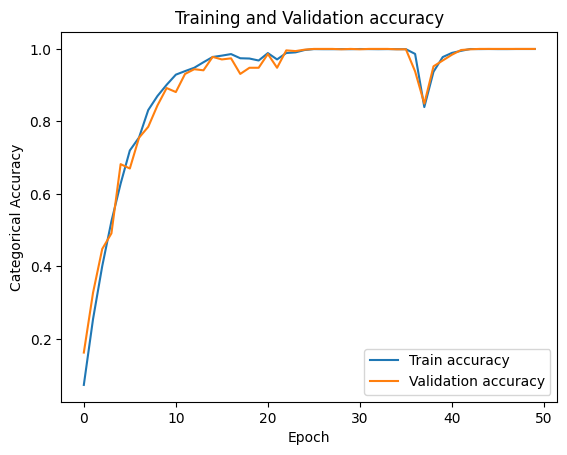

In [27]:
# Plot the training and validation loss curves
plt.plot(history.history['accuracy'], label='Train accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
# plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Categorical Accuracy')
plt.legend()
plt.show()

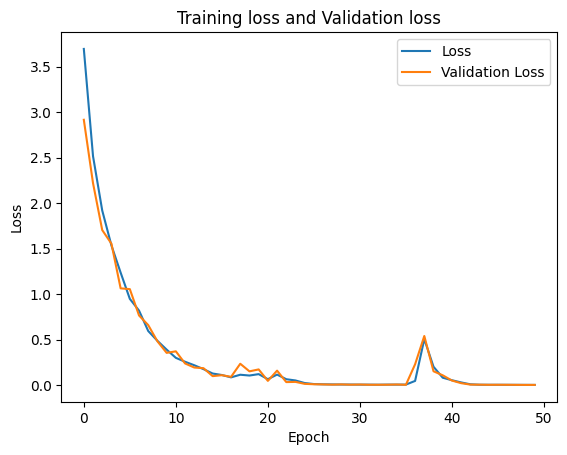

In [28]:
# Plot the training and validation loss curves
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training loss and Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

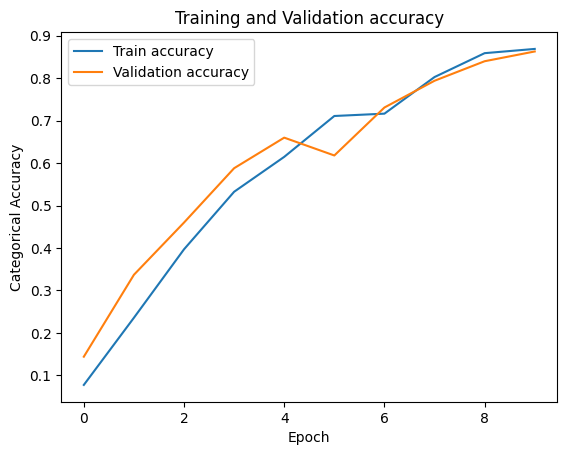

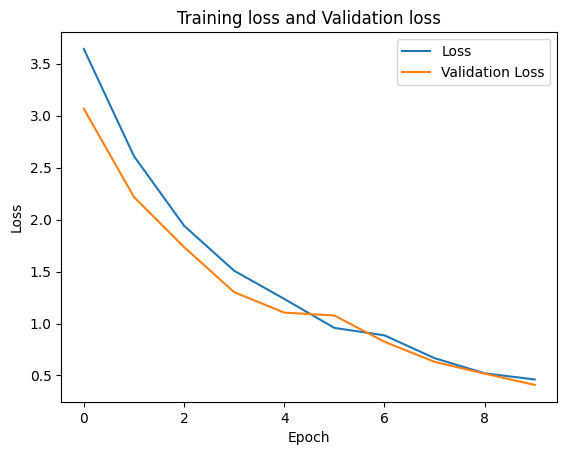

In [74]:
# Plot the training and validation loss curves
plt.plot(history2.history['accuracy'], label='Train accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation accuracy')
# plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Categorical Accuracy')
plt.legend()
plt.show()

# Plot the training and validation loss curves
plt.plot(history2.history['loss'], label='Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
# plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training loss and Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

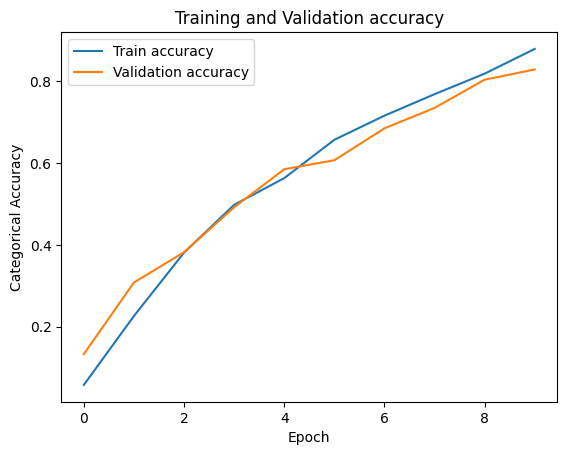

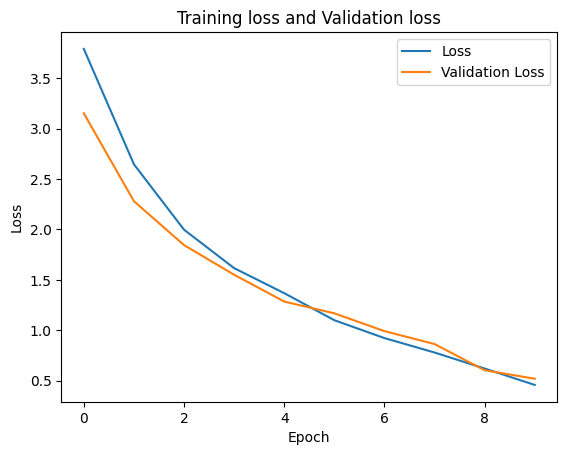

In [75]:
# Plot the training and validation loss curves
plt.plot(history3.history['accuracy'], label='Train accuracy')
plt.plot(history3.history['val_accuracy'], label='Validation accuracy')
# plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Categorical Accuracy')
plt.legend()
plt.show()

# Plot the training and validation loss curves
plt.plot(history3.history['loss'], label='Loss')
plt.plot(history3.history['val_loss'], label='Validation Loss')
# plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training loss and Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

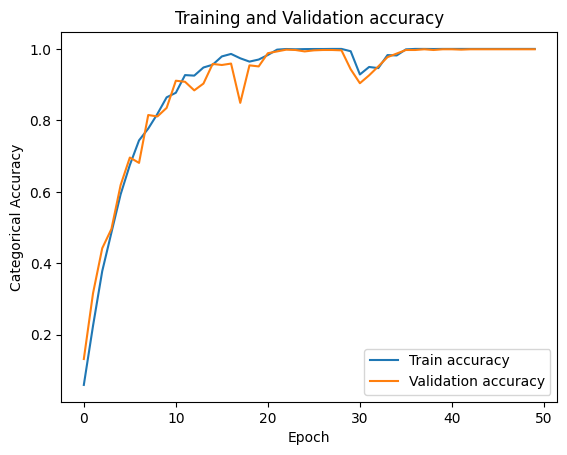

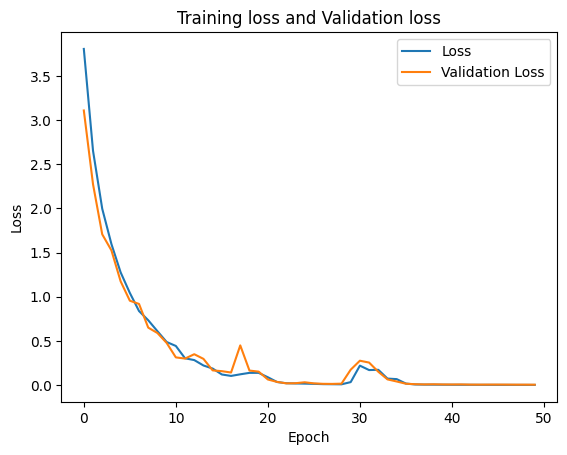

In [79]:
# Plot the training and validation loss curves
plt.plot(history3.history['accuracy'], label='Train accuracy')
plt.plot(history3.history['val_accuracy'], label='Validation accuracy')
# plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Categorical Accuracy')
plt.legend()
plt.show()

# Plot the training and validation loss curves
plt.plot(history3.history['loss'], label='Loss')
plt.plot(history3.history['val_loss'], label='Validation Loss')
# plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training loss and Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [39]:
# Create the model
model2 = create_transformer_model(X_train.shape[1],X_train.shape[2],50,1,225,4,0.2)

In [40]:
history2 = model2.fit(X_train, y_train, batch_size=64, epochs=10, validation_data=(X_valid,y_valid))

Epoch 1/10
63/63 [==============================] - 38s 582ms/step - loss: 3.6428 - accuracy: 0.0775 - val_loss: 3.0673 - val_accuracy: 0.1440
Epoch 2/10
63/63 [==============================] - 37s 593ms/step - loss: 2.6119 - accuracy: 0.2358 - val_loss: 2.2179 - val_accuracy: 0.3370
Epoch 3/10
63/63 [==============================] - 38s 610ms/step - loss: 1.9421 - accuracy: 0.3970 - val_loss: 1.7363 - val_accuracy: 0.4600
Epoch 4/10
63/63 [==============================] - 38s 599ms/step - loss: 1.5081 - accuracy: 0.5325 - val_loss: 1.3019 - val_accuracy: 0.5880
Epoch 5/10
63/63 [==============================] - 38s 598ms/step - loss: 1.2374 - accuracy: 0.6148 - val_loss: 1.1054 - val_accuracy: 0.6600
Epoch 6/10
63/63 [==============================] - 37s 593ms/step - loss: 0.9581 - accuracy: 0.7110 - val_loss: 1.0775 - val_accuracy: 0.6180
Epoch 7/10
63/63 [==============================] - 38s 599ms/step - loss: 0.8865 - accuracy: 0.7165 - val_loss: 0.8248 - val_accuracy: 0.7310

In [61]:
# Create the model
model3 = create_transformer_model(X_train.shape[1],X_train.shape[2],50,1,225,4,0.2)
history3 = model3.fit(X_train, y_train, batch_size=64, epochs=10, validation_data=(X_valid,y_valid))

Epoch 1/10
63/63 [==============================] - 63s 981ms/step - loss: 3.7917 - accuracy: 0.0575 - val_loss: 3.1526 - val_accuracy: 0.1330
Epoch 2/10
63/63 [==============================] - 59s 941ms/step - loss: 2.6467 - accuracy: 0.2260 - val_loss: 2.2802 - val_accuracy: 0.3080
Epoch 3/10
63/63 [==============================] - 65s 1s/step - loss: 1.9976 - accuracy: 0.3810 - val_loss: 1.8447 - val_accuracy: 0.3820
Epoch 4/10
63/63 [==============================] - 63s 998ms/step - loss: 1.6160 - accuracy: 0.4980 - val_loss: 1.5504 - val_accuracy: 0.4920
Epoch 5/10
63/63 [==============================] - 64s 1s/step - loss: 1.3676 - accuracy: 0.5633 - val_loss: 1.2843 - val_accuracy: 0.5850
Epoch 6/10
63/63 [==============================] - 65s 1s/step - loss: 1.0992 - accuracy: 0.6570 - val_loss: 1.1675 - val_accuracy: 0.6070
Epoch 7/10
63/63 [==============================] - 64s 1s/step - loss: 0.9217 - accuracy: 0.7160 - val_loss: 0.9909 - val_accuracy: 0.6850
Epoch 8/10


In [77]:
# Create the model
model4 = create_transformer_model(X_train.shape[1],X_train.shape[2],50,1,225,4,0.2)
history3 = model4.fit(X_train, y_train, batch_size=64, epochs=50, validation_data=(X_valid,y_valid))

Epoch 1/50
63/63 [==============================] - 35s 543ms/step - loss: 3.8048 - accuracy: 0.0595 - val_loss: 3.1082 - val_accuracy: 0.1320
Epoch 2/50
63/63 [==============================] - 35s 549ms/step - loss: 2.6519 - accuracy: 0.2250 - val_loss: 2.2732 - val_accuracy: 0.3160
Epoch 3/50
63/63 [==============================] - 33s 532ms/step - loss: 1.9961 - accuracy: 0.3780 - val_loss: 1.7067 - val_accuracy: 0.4420
Epoch 4/50
63/63 [==============================] - 33s 532ms/step - loss: 1.5963 - accuracy: 0.4860 - val_loss: 1.5245 - val_accuracy: 0.4960
Epoch 5/50
63/63 [==============================] - 45s 714ms/step - loss: 1.2760 - accuracy: 0.5930 - val_loss: 1.1746 - val_accuracy: 0.6190
Epoch 6/50
63/63 [==============================] - 35s 551ms/step - loss: 1.0432 - accuracy: 0.6750 - val_loss: 0.9550 - val_accuracy: 0.6960
Epoch 7/50
63/63 [==============================] - 34s 544ms/step - loss: 0.8379 - accuracy: 0.7440 - val_loss: 0.9183 - val_accuracy: 0.6810

In [52]:
model2.save('Tr_120_Full_1.h5')

In [73]:
model3.save('Tr_120_AugmentedOnly_2.h5')

In [11]:
model3.load_weights('Tr_120_AugmentedOnly_1.h5')

In [80]:
res = model4.predict(X_valid)

32/32 [==============================] - 3s 92ms/step


In [81]:
actions[np.argmax(res[2])]

'Untuk'

In [82]:
actions[np.argmax(y_valid[2])]

'Untuk'

In [83]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [84]:
yhat = model3.predict(X_valid)

32/32 [==============================] - 3s 95ms/step


In [85]:
ytrue = np.argmax(y_valid, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [86]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[980,   0],
        [  1,  19]],

       [[980,   0],
        [ 12,   8]],

       [[974,   6],
        [  5,  15]],

       [[977,   3],
        [  6,  14]],

       [[979,   1],
        [  1,  19]],

       [[970,  10],
        [  3,  17]],

       [[977,   3],
        [  0,  20]],

       [[968,  12],
        [  0,  20]],

       [[979,   1],
        [  5,  15]],

       [[976,   4],
        [ 10,  10]],

       [[978,   2],
        [ 10,  10]],

       [[980,   0],
        [  4,  16]],

       [[979,   1],
        [  6,  14]],

       [[972,   8],
        [  0,  20]],

       [[977,   3],
        [  3,  17]],

       [[979,   1],
        [  0,  20]],

       [[979,   1],
        [  3,  17]],

       [[979,   1],
        [  8,  12]],

       [[980,   0],
        [  0,  20]],

       [[980,   0],
        [  2,  18]],

       [[978,   2],
        [  0,  20]],

       [[972,   8],
        [  0,  20]],

       [[980,   0],
        [  0,  20]],

       [[980,   0],
        [  5, 

In [87]:
accuracy_score(ytrue, yhat)

0.829

In [71]:
for i in range(50):
    result = actions[np.argmax(res[i])]

    print(result +" " + str(i))  

Dia 0
Apa 1
Untuk 2
Ini 3
Dengan 4
Kumpul 5
Kumpul 6
Dari 7
Mereka 8
Kumpul 9
Beberapa 10
Mereka 11
Saya 12
Dia 13
Mereka 14
Apa 15
Akan 16
Beberapa 17
Kumpul 18
Tangan 19
Lain 20
Kata 21
Bagaimana 22
Tangan 23
Beberapa 24
Rumah 25
Oleh 26
Bisa 27
Tangan 28
Tambah 29
Yang 30
Tiga 31
Masing 32
Anda 33
Mereka 34
Kami 35
Pada 36
Saya 37
Dari 38
Udara 39
Juga 40
Satu 41
Bagaimana 42
Udara 43
Laku 44
Makan 45
Dengan 46
Beberapa 47
Rumah 48
Satu 49


In [72]:
actions[np.argmax(res[1])]

'Apa'

In [28]:
colors = [(245,117,16), (117,245,16), (16,117,245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

In [29]:
import mediapipe as mp

In [30]:
def find_body_centroid(landmarks, main_body):
    if landmarks: ### jika landmark ditemukan
        x_bodies = []
        y_bodies = []
        z_bodies = []
        for i in main_body:
            x_bodies.append(landmarks.landmark[i].x)
            y_bodies.append(landmarks.landmark[i].y)
            z_bodies.append(landmarks.landmark[i].z)
        glob_bbox = [x_bodies, y_bodies, z_bodies]
        return np.average(x_bodies), np.average(y_bodies), np.average(z_bodies)
    else: ### jika landmark tidak ditemukan
        return 0, 0, 0

In [ ]:
def euclidean(a, b):
    sum_sq = np.sum(np.square(a - b)) ## sumasi dari kedua titik
    euclidean = np.sqrt(sum_sq) ## akar kuadrat dari sumasi

    return euclidean

def pixel_match(coordinates, w, h): # rescaling keypoints menyesuaikan resolusi frame
    x = int(coordinates[0] * w)
    y = int(coordinates[1] * h)
    coordinates[0] = x
    coordinates[1] = y

    return coordinates


def landmarks_data(landmarks, data, key):
    radius = data["radius"]
    px_radius = data["px_radius"]
    centroid = data["centroid"]
    coordinates = []
    centroid_x = centroid[0]
    centroid_y = centroid[1]
    original_h = data["image"].shape[0]
    original_w = data["image"].shape[1]
    px_centroid_x, px_centroid_y = pixel_match([centroid_x, centroid_y], original_w, original_h)
    x = 0
    if landmarks:
        for i in landmarks.landmark:
            horizontal = px_centroid_x - px_radius # selisih kanan/kiri
            vertical = px_centroid_y - px_radius # selisih atas/bawah

            px_x, px_y = pixel_match([i.x, i.y], original_w, original_h)
            
            if px_x >= 0: 
                normalized_px_x = abs(horizontal - px_x) 
            else:  
                normalized_px_x = -abs(horizontal - px_x) 
            if px_y >= 0: 
                normalized_px_y = abs(vertical - px_y) 
            else: 
                normalized_px_y = -abs(vertical - px_y)

            # data["img_pixel"] = np.zeros([10*px_radius,10*px_radius,3],dtype=np.uint8)
            # data["img_pixel"].fill(155) # or img[:] = 155
            
            data["img_pixel"] = data["image"]
            data["img_pixel"] = cv2.circle(data["img_pixel"], (px_x,px_y), radius=5, color=(66,66,245), thickness=3)
            data["img_pixel"] = cv2.circle(data["img_pixel"], (int(centroid_x), int(centroid_y)), radius=5, color=(255,255,255), thickness=5)
            data["img_pixel"] = cv2.circle(data["img_pixel"], (normalized_px_x,normalized_px_y), radius=5, color=(62,184,64), thickness=3)
            data["img_pixel"] = cv2.circle(data["img_pixel"], (int(px_centroid_x),int(px_centroid_y)), radius=5, color=(255,251,28), thickness=5)
            #cv2.imwrite(os.path.join(data["data_save_path"])+'/'+str(data["frame_index"])+'_real_.jpg', data["img_pixel"])
            # from matplotlib import pyplot as plt
            # plt.imshow(data["img_pixel"], interpolation='nearest')
            # plt.show()


            # agar skala tidak melebihi 1.92
            i.x = normalized_px_x / (2 * px_radius) #px_radius nilainya sekitar +-500pixel
            i.y = normalized_px_y / (2 * px_radius)
            # i.x = px_x / (2 * px_radius) #px_radius nilainya sekitar +-500pixel
            # i.y = px_y / (2 * px_radius)
            # horizontal_unpix = horizontal / (2 * px_radius)
            # vertical_unpix =  vertical / (2 * px_radius)

            # print(horizontal_unpix, vertical_unpix)

            
            ### cek px_radius, px_centroid_x, px_centroid_y, horizontal dan vertical
            # print("================================")
            # print(data["radius"], data["centroid"], data["data_save_path"])
            # print(px_radius, px_centroid_x, px_centroid_y, horizontal, vertical)
            # print(normalized_px_x, normalized_px_y, px_x, px_y, i.x, i.y)
            #print(str(px_radius))
            # i.x = px_x
            # i.y = px_y
            # print("pixel_asli : "+str([px_x, px_y])+"pixel_normalized : "+str([normalized_px_x,normalized_px_y])+"ix_iy : "+str([i.x,i.y]))
            # hasilnya
            # pixel_asli : [723, 927] pixel_normalized : [795, 943] ix_iy : [0.7443820238113403, 0.8829588294029236]
            # pixel_asli : [679, 968] pixel_normalized : [751, 984] ix_iy : [0.7031835317611694, 0.9213483333587646]
            # pixel_asli : [659, 1017] pixel_normalized : [731, 1033] ix_iy : [0.6844569444656372, 0.9672284722328186]
            # pixel_asli : [653, 1054] pixel_normalized : [725, 1070] ix_iy : [0.6788389682769775, 1.0018726587295532]
            # pixel_asli : [648, 1081] pixel_normalized : [720, 1097] ix_iy : [0.6741573214530945, 1.0271536111831665]
            # pixel_asli : [691, 1041] pixel_normalized : [763, 1057] ix_iy : [0.7144194841384888, 0.9897003769874573]
            # pixel_asli : [684, 1088] pixel_normalized : [756, 1104] ix_iy : [0.7078651785850525, 1.033707857131958]
            # pixel_asli : [674, 1117] pixel_normalized : [746, 1133] ix_iy : [0.6985018849372864, 1.0608614683151245]
            # pixel_asli : [665, 1138] pixel_normalized : [737, 1154] ix_iy : [0.6900749206542969, 1.0805243253707886]
            # pixel_asli : [713, 1041] pixel_normalized : [785, 1057] ix_iy : [0.7350187301635742, 0.9897003769874573]
            # pixel_asli : [705, 1089] pixel_normalized : [777, 1105] ix_iy : [0.7275280952453613, 1.0346442461013794]
            coordinates.append(i.x)
            coordinates.append(i.y)
            coordinates.append(i.z)
            x += 1
    else: ### kalo landmarks tidak ditemukan kosongkan saja semua keypoints di tubuh/tangan
        if key == "hand":
            vertex_num = 21
        if key == "pose":
            vertex_num = 33
        for i in range(0, vertex_num):
            for i in range(0, 3):
                coordinates.append(0)

    return coordinates, landmarks
